# LMRv2.x validation

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)
import pens
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

octave not found, please see README
2024.11.6


## Load Recon Job

Plot tas climate field reconstruction (mean over ensembles) and time series 

In [2]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda/')
res.load(['tas_gm', 'tas'])

## Validate GMST 

Firstly against LMR offline

### Load LMR offline 
We can do this using Pangeo-Forge. We then need to take the average over lat/lon in order to get the global mean surface temperature. We can then turn this into an Ensemble Time Series for more convenient plotting and comparison. 

In [48]:
lmr_off = xr.open_dataset('./prev_data/gmt_MCruns_ensemble_full_LMRv2.1.nc')
lmr_off


<xarray.Dataset> Size: 16MB
Dimensions:  (time: 2001, MCrun: 20, members: 100)
Coordinates:
  * time     (time) object 16kB 0000-01-01 00:00:00 ... 2000-01-01 00:00:00
Dimensions without coordinates: MCrun, members
Data variables:
    gmt      (time, MCrun, members) float32 16MB ...
Attributes:
    description:  Last Millennium Reanalysis climate field reconstruction for...
    experiment:   productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    comment:      File contains full ensemble values for each Monte-Carlo rec...

In [53]:
ens_values = lmr_off.gmt.stack(ensemble=['MCrun', 'members']).values  # Shape: (time, MCrun*members)
time_values = lmr_off.time.values
years = np.array([t.year for t in time_values])

(<Figure size 1200x400 with 1 Axes>,
 <Axes: xlabel='Year (CE)', ylabel='Temperature Anomaly (°C)'>)

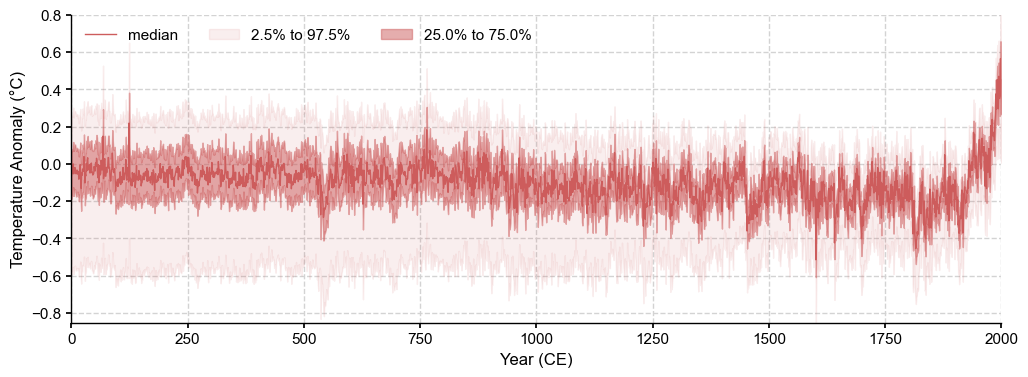

In [54]:
lmr_ens = cfr.EnsTS(time=years, value=ens_values, value_name='Temperature Anomaly (°C)')
lmr_ens.plot_qs()

### Load GMST from our Recon Job 

In [49]:
res_ts = res.recons['tas_gm']

### Plot both versions of LMR to see comparison


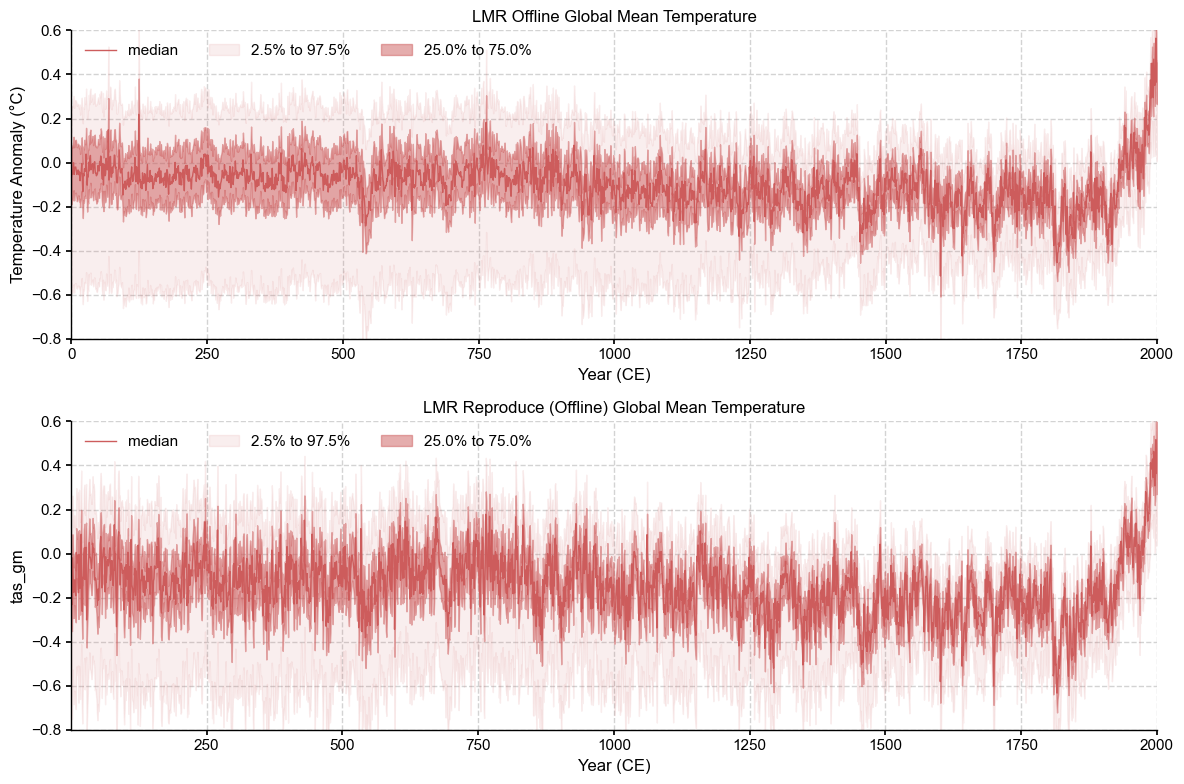

In [66]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

res_ts.plot_qs(ax=ax2, ylim=[-0.8, 0.6])
ax2.set_title('LMR Reproduce (Offline) Global Mean Temperature')

lmr_ens.plot_qs(ax=ax1, ylim=[-0.8, 0.6]) 
ax1.set_title('LMR Offline Global Mean Temperature')

plt.tight_layout()
plt.show()

### Comparison using PENS

In [72]:
import pens
import seaborn as sns

plt.style.use('default')
pens.set_style()

In [73]:
# Convert cfr EnsTS to pens EnsTS
glob_pens = pens.EnsembleTS(time=lmr_ens.time, value=lmr_ens.value)
glob_pens.label = 'Original LMR'
glob_pens.time_unit = 'years'
glob_pens.value_name = 'GMST'
glob_pens.value_unit = '\N{DEGREE SIGN}C'

res_pens = pens.EnsembleTS(time=res_ts.time, value=res_ts.value)
res_pens.label = 'Reproduced LMR'
res_pens.time_unit = 'years'
res_pens.value_name = 'GMST'
res_pens.value_unit = '\N{DEGREE SIGN}C'

In [74]:
# Align time dimension for both EnsTS

glob_time = lmr_ens.time
res_time = res_ts.time.values

common_start = max(glob_time.min(), res_time.min())
common_end = min(glob_time.max(), res_time.max())

# Create time range array
timespan = np.array([common_start, common_end])

# Slice to common period
glob_pens_aligned = glob_pens.slice(timespan)
res_pens_aligned = res_pens.slice(timespan)

In [75]:
orig_intra = glob_pens_aligned.distance()
repro_intra = res_pens_aligned.distance()

# Calculate inter-ensemble distance 
inter_dist = glob_pens_aligned.distance(res_pens_aligned.value)
    
# Calculate plume distance 
plume_dist = glob_pens_aligned.plume_distance(res_pens_aligned.value, max_dist=1.0)


Computing intra-ensemble distance among possible pairs: 100%|██████████| 1999000/1999000 [00:42<00:00, 46592.32it/s]
Computing intra-ensemble distance among possible pairs: 100%|██████████| 12497500/12497500 [04:04<00:00, 51051.60it/s]
Computing inter-ensemble distance: 100%|██████████| 2000/2000 [03:31<00:00,  9.48it/s]


In [81]:
print("\nDistances between ensembles:")
print(f"Original intra-ensemble distance : {orig_intra},\ len={len(orig_intra)}", )
print(f"Reproduced intra-ensemble distance: {repro_intra},\ len={len(repro_intra)}")
print(f"Inter-ensemble distance: {inter_dist}")
print(f"Plume distance: {plume_dist}")


Distances between ensembles:
Original intra-ensemble distance : [0.40367679 0.21343417 0.04743079 ... 0.26221506 0.05118074 0.29547632],\ len=1999000
Reproduced intra-ensemble distance: [0.94789544 0.09056072 0.28877796 ... 0.20300755 0.14063556 0.06237199],\ len=12497500
Inter-ensemble distance: [0.26640526 0.6819875  0.1788533  ... 0.24184856 0.44452382 0.38215183]
Plume distance: 0.15295353638863274


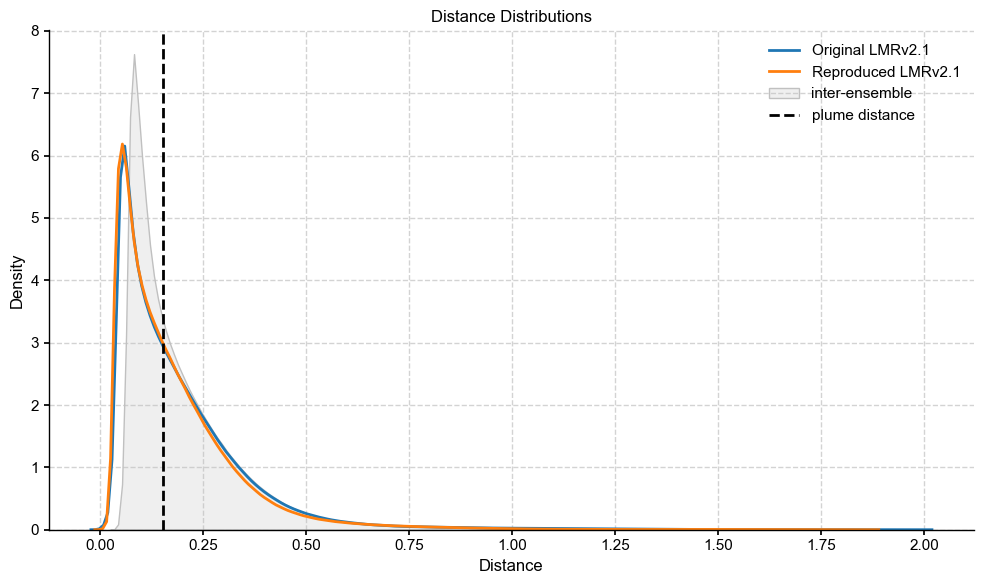

In [85]:
# Create figure and plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot KDE for individual ensembles with explicit labels
sns.kdeplot(data=orig_intra, fill=False, ax=ax, common_norm=False, label='Original LMRv2.1')
sns.kdeplot(data=repro_intra, fill=False, ax=ax, common_norm=False, label='Reproduced LMRv2.1')

# Add inter-ensemble distribution
sns.kdeplot(data=inter_dist, fill=True, ax=ax, common_norm=False, color='silver', 
            label='inter-ensemble')

# Add plume distance line
ax.axvline(x=plume_dist, color="black", linestyle="--", label='plume distance')

# Add labels
ax.set_xlabel('Distance')
ax.set_ylabel('Density')
ax.set_title('Distance Distributions')
ax.legend()

plt.tight_layout()
plt.show()

### Load HadCRUT4

load dataset using xarray, then convert to a cfr Ensemble Time Series object

In [29]:
had = xr.load_dataset('./analyses/HadCRUT/HadCRUT.4.4.0.0.median.nc')
had.head()

<xarray.Dataset> Size: 585B
Dimensions:              (latitude: 5, longitude: 5, time: 5)
Coordinates:
  * latitude             (latitude) float32 20B -87.5 -82.5 -77.5 -72.5 -67.5
  * longitude            (longitude) float32 20B -177.5 -172.5 ... -162.5 -157.5
  * time                 (time) datetime64[ns] 40B 1850-01-16T12:00:00 ... 18...
Data variables:
    temperature_anomaly  (time, latitude, longitude) float32 500B nan ... nan
    field_status         (time) |S1 5B b'f' b'f' b'f' b'f' b'f'
Attributes:
    title:                  HadCRUT4 near-surface temperature ensemble data -...
    institution:            Met Office Hadley Centre / Climatic Research Unit...
    history:                Updated at 28/10/2015 10:05:21
    source:                 CRUTEM.4.4.0.0, HadSST.3.1.1.0
    comment:                
    reference:              Morice, C. P., J. J. Kennedy, N. A. Rayner, and P...
    version:                HadCRUT.4.4.0.0
    Conventions:            CF-1.0
    ensemble_members:       100
    ensemble_member_index:  0

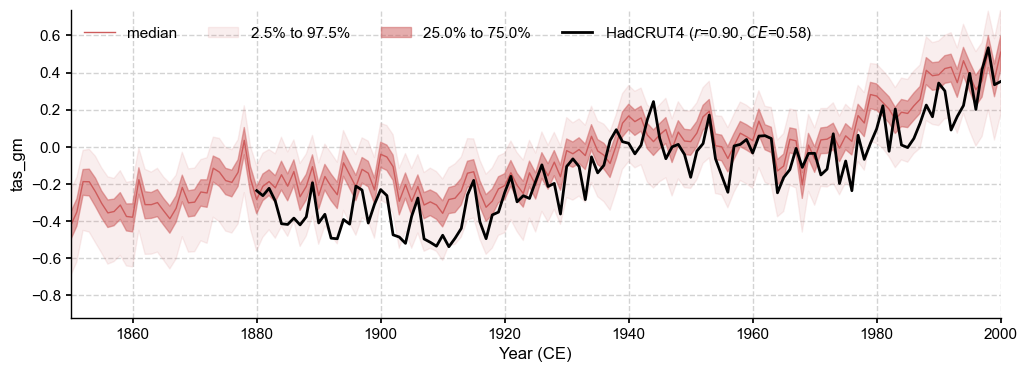

In [30]:
gm = had.temperature_anomaly.mean(dim=['latitude', 'longitude'])
had_annual = gm.groupby('time.year').mean()

# Make sure values are properly shaped ([,:1])
had_values = had_annual.values
if had_values.ndim == 1:
    had_values = had_values[:, np.newaxis] 

# annualize HadCRUT4
had_ts_annual = cfr.EnsTS(
    time=had_annual.year.values,
    value=had_values,
    value_name='Temperature Anomaly'
)

# Compare LMR with annual data
had_ts_compared = res_ts.compare(
    had_ts_annual, 
    ref_name='HadCRUT4', 
    timespan=(1880, 2000)
)

fig, ax = had_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850,2000])

### Load GISTEMP

In [31]:
gis = xr.load_dataset('./analyses/GISTEMP/gistemp1200_ERSSTv4.nc')
gis.head()

<xarray.Dataset> Size: 660B
Dimensions:      (lat: 5, lon: 5, time: 5, nv: 2)
Coordinates:
  * lat          (lat) float32 20B -89.0 -87.0 -85.0 -83.0 -81.0
  * lon          (lon) float32 20B -179.0 -177.0 -175.0 -173.0 -171.0
  * time         (time) datetime64[ns] 40B 1880-01-15 1880-02-15 ... 1880-05-15
Dimensions without coordinates: nv
Data variables:
    time_bnds    (time, nv) datetime64[ns] 80B 1880-01-01 ... 1880-06-01
    tempanomaly  (time, lat, lon) float32 500B nan nan nan nan ... nan nan nan
Attributes:
    title:        GISTEMP Surface Temperature Analysis
    institution:  NASA Goddard Institute for Space Studies
    source:       http://data.giss.nasa.gov/gistemp/
    Conventions:  CF-1.6
    history:      Created 2017-05-12 10:40:20 by SBBX_to_nc 2.0 - ILAND=1200,...

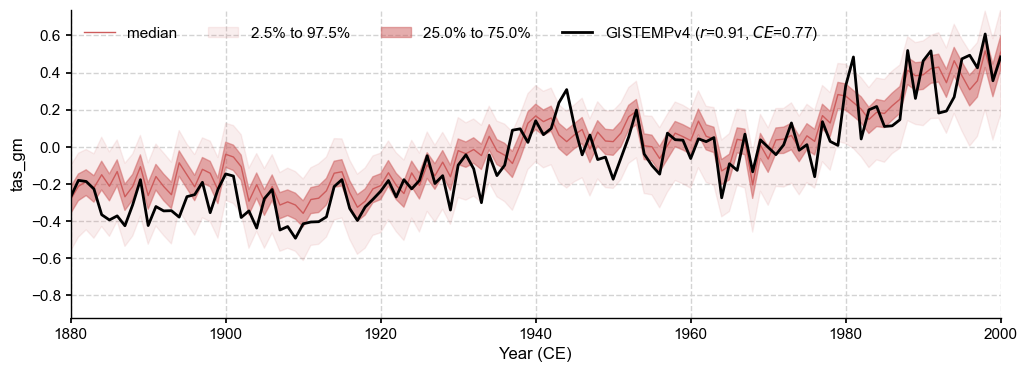

In [32]:
gm = gis.tempanomaly.mean(dim=['lat', 'lon'])
gis_annual = gm.groupby('time.year').mean()

# Make sure values are properly shaped ([,:1])
gis_values = gis_annual.values
if gis_values.ndim == 1:
    gis_values = gis_values[:, np.newaxis] 

# annualize GISTEMP
gis_ts_annual = cfr.EnsTS(
    time=gis_annual.year.values,
    value=gis_values,
    value_name='Temperature Anomaly'
)

# Compare LMR with annual data
gis_ts_compared = res_ts.compare(
    gis_ts_annual, 
    ref_name='GISTEMPv4', 
    timespan=(1880, 2000)
)

fig, ax = gis_ts_compared.plot_qs(figsize=[12, 4], xlim=[1880,2000])

### Load Berkeley Earth Surface Temperature

In [33]:
best = xr.load_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')
best

<xarray.Dataset> Size: 517MB
Dimensions:      (longitude: 360, latitude: 180, time: 1980, month_number: 12)
Coordinates:
  * longitude    (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude     (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time         (time) float64 16kB 1.85e+03 1.85e+03 ... 2.015e+03 2.015e+03
Dimensions without coordinates: month_number
Data variables:
    land_mask    (latitude, longitude) float64 518kB 1.0 1.0 1.0 ... 0.0 0.0 0.0
    temperature  (time, latitude, longitude) float32 513MB nan nan ... 0.4641
    climatology  (month_number, latitude, longitude) float32 3MB -28.21 ... -...
Attributes:
    Conventions:           Berkeley Earth Internal Convention (based on CF-1.5)
    title:                 Native Format Berkeley Earth Surface Temperature A...
    history:               17-Feb-2015 11:17:51
    institution:           Berkeley Earth Surface Temperature Project
    land_source_history:   16-Jan-2015 09:30:27
    ocean_source_history:  08-Jan-2015 06:07:03
    comment:               This file contains Berkeley Earth surface temperat...

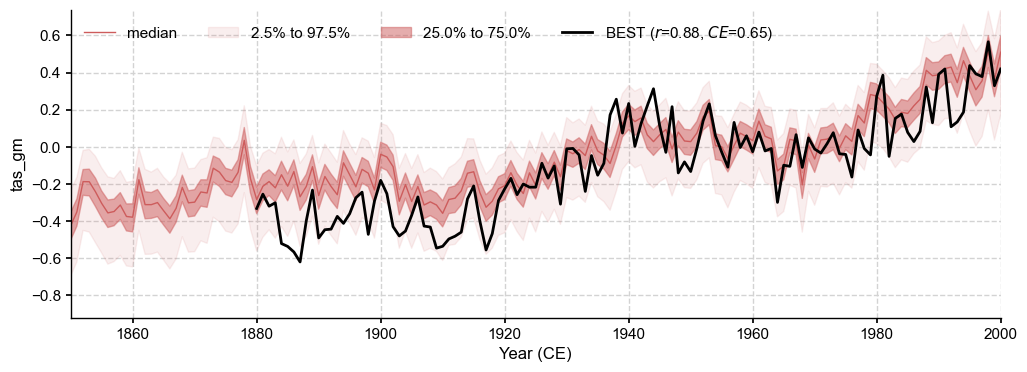

In [34]:

gm = best.temperature.mean(dim=['latitude', 'longitude'])

# Convert time coordinate to datetime index (specific to BEST)
time_index = pd.date_range(start='1850-01-01', periods=len(best.time), freq='M')
gm = gm.assign_coords(time=time_index)

best_annual = gm.groupby('time.year').mean()

# Reshape values if needed
best_values = best_annual.values
if best_values.ndim == 1:
    best_values = best_values[:, np.newaxis]

# annualize
best_ts_annual = cfr.EnsTS(
    time=best_annual.year.values,
    value=best_values,
    value_name='Temperature Anomaly'
)

# Compare LMR with annual data
best_ts_compared = res_ts.compare(
    best_ts_annual,
    ref_name='BEST',
    timespan=(1880, 2000)
)

fig, ax = best_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850, 2000])

### Plot all together 

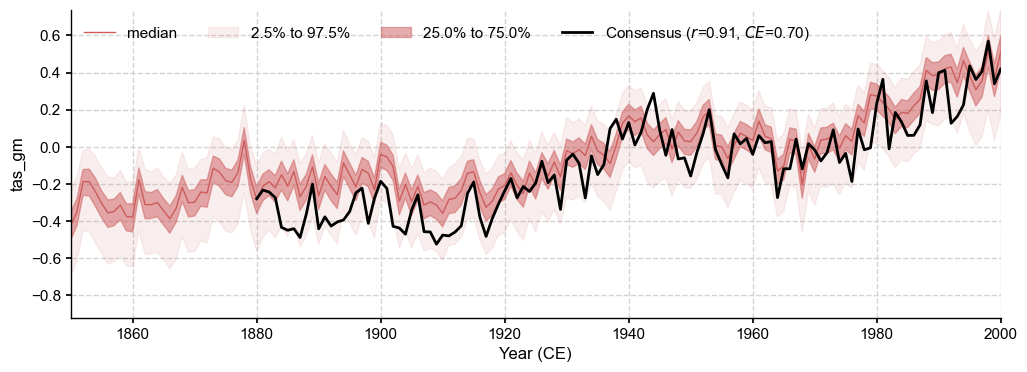

In [35]:
# combine all datasets to calculate mean
all_refs = np.array([
   had_ts_compared.ref_value[:121],
   gis_ts_compared.ref_value[:121],
   best_ts_compared.ref_value[:121]
])
mean_ref = np.mean(all_refs, axis=0)

mean_ts_annual = cfr.EnsTS(
    time=best_annual.year.values[30:-14], #manually slice dates
    value=mean_ref,
    value_name='Temperature Anomaly'
)

mean_ts_compared = res_ts.compare(
    mean_ts_annual,
    ref_name='Consensus',
    timespan=(1880, 2000)
)

fig, ax = mean_ts_compared.plot_qs(figsize=[12, 4], xlim=[1850, 2000])

Text(0.5, 1.0, 'LMRv2.x vs Observational Data 1880-2000')

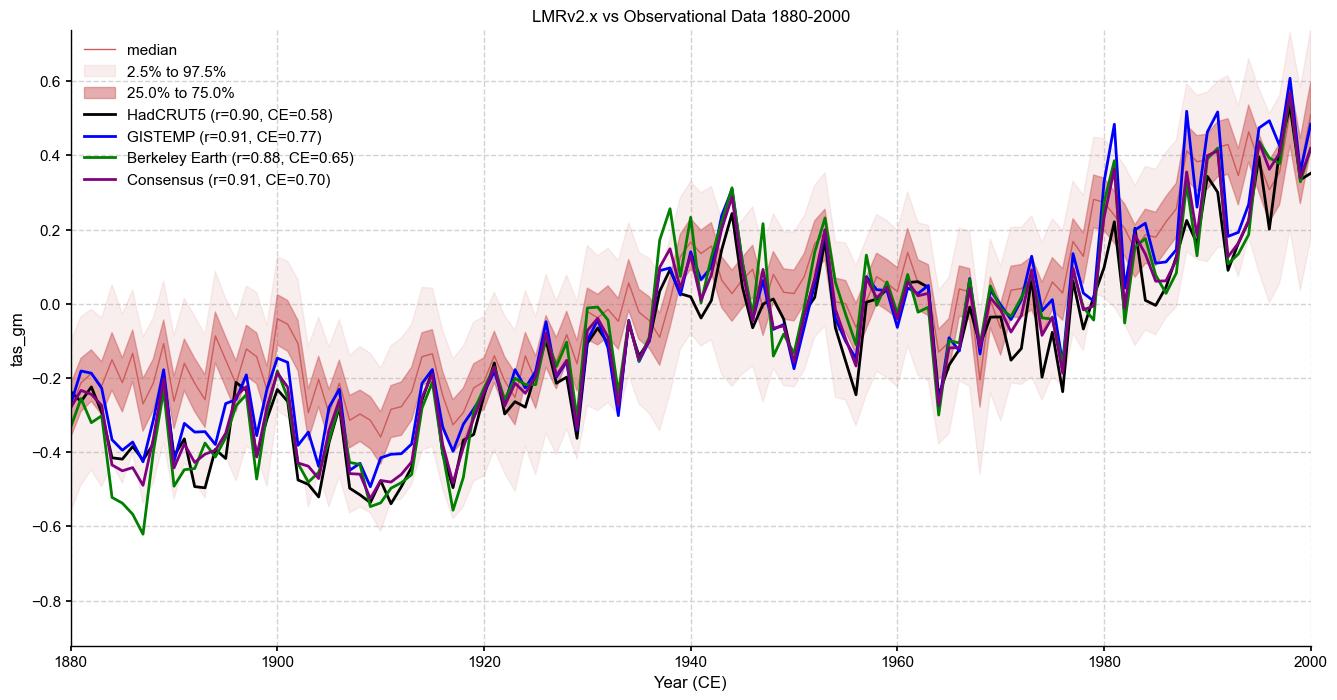

In [36]:
# Create base plot without validation plot
fig, ax = had_ts_compared.plot_qs(
   figsize=[16, 8], 
   xlim=(1880, 2000),
   color='indianred',
   plot_valid=False 
)

for compared, color, label in [
   (had_ts_compared, 'black', 'HadCRUT5'),
   (gis_ts_compared, 'blue', 'GISTEMP'),
   (best_ts_compared, 'green', 'Berkeley Earth'),
   (mean_ts_compared, 'purple', 'Consensus')
   
]:
   stats = compared.valid_stats
   label = f'{label} (r={stats["corr"]:.2f}, CE={stats["CE"]:.2f})'
   ax.plot(compared.ref_time, compared.ref_value[:121], color=color, label=label)


plt.legend()
plt.title('LMRv2.x vs Observational Data 1880-2000')

## Validate tas climate field

### Load field reconstruction 

(<Figure size 1000x800 with 2 Axes>, <GeoAxes: title={'center': 'tas, 1'}>)

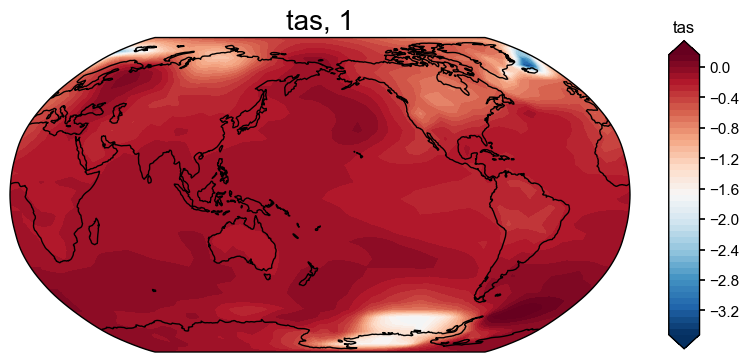

In [37]:
res_tas = res.recons['tas']
res_tas.plot()

### Load GISTEMP temperature field 

The Tardif et al. paper uses BEST for field validation, but it did not work with cfr for some reason. GISTEMP had the highest correlation for time series validation, and hence I decided to try it for the field validation as well. 

In [95]:
target = cfr.ClimateField().load_nc(
    path='./analyses/GISTEMP/gistemp1200_ERSSTv5.nc',
    vn='tempanomaly', 
    time_name='time',  
    lat_name='lat', 
    lon_name='lon',
    use_cftime=True).get_anom((1951,1980))

In [96]:
target = target.annualize(months=[12, 1, 2])
target.da

<xarray.DataArray 'tempanomaly' (time: 139, lat: 90, lon: 180)> Size: 9MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ],
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ],
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333],
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333],
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time     (time) int64 1kB 1880 1881 1882 1883 1884 ... 2015 2016 2017 2018
Attributes:
    annualized:  1

#### Correlation

In [97]:
valid_fd = res.recons['tas'].compare(
    target, stat='corr',
    timespan=(1880, 2000),
)

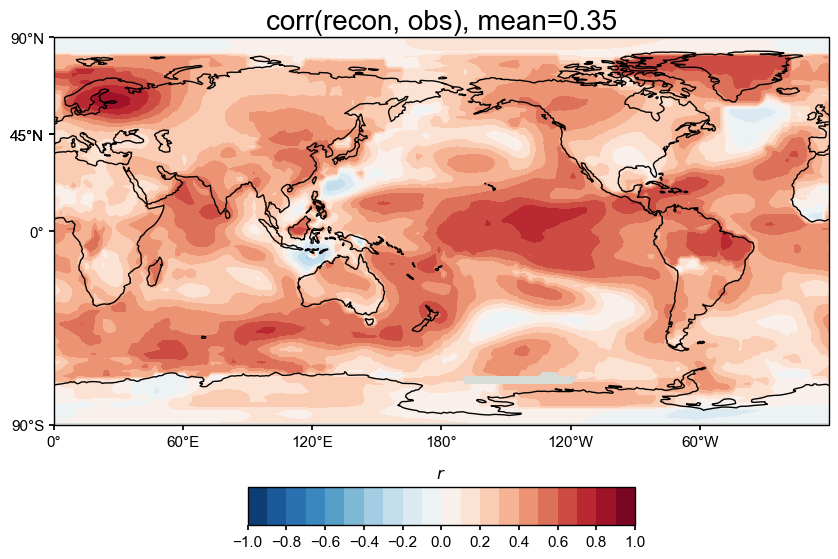

In [98]:
valid_fd.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fd.plot(
    title=f'corr(recon, obs), mean={valid_fd.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True, plot_proxydb=False,
)

cfr.showfig(fig)

#### CE (coefficient of efficiency)

In [99]:
valid_fdx = res.recons['tas'].compare(
    target, stat='CE',
    timespan=(1880, 2000),
)

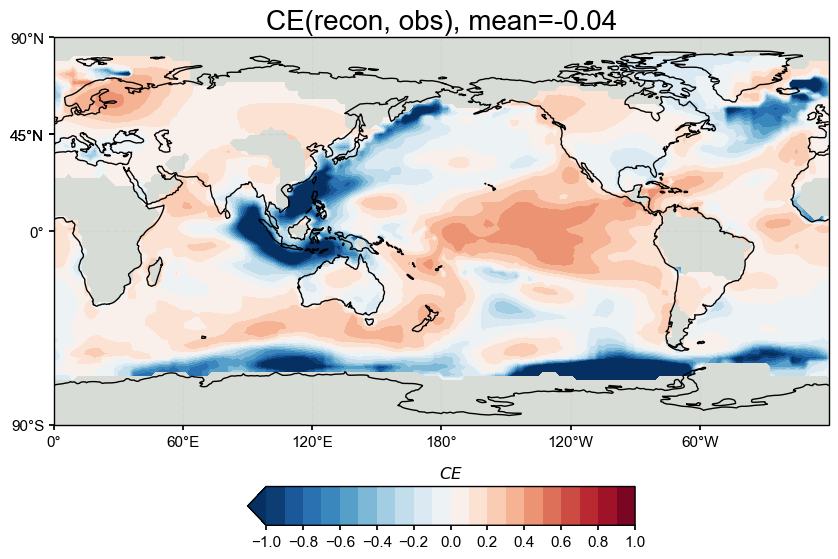

In [100]:
valid_fdx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})

fig, ax = valid_fdx.plot(
    title=f'CE(recon, obs), mean={valid_fdx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True, plot_proxydb=False,
)

cfr.showfig(fig)

## Trying BEST again
Same process as above, but wrapping the longitude and alterating time array to be in datetime format.

In [102]:
ds = xr.open_dataset('./analyses/BerkeleyEarth/Land_and_Ocean_LatLong1.nc')

# 2. Convert decimal years to datetime
years = ds.time.values
dates = pd.to_datetime([f"{int(year)}-{int((year % 1) * 12 + 1):02d}-15" for year in years])

# 3. Create a new DataArray with proper coordinates
da = xr.DataArray(
    ds.temperature.values,
    coords={
        'time': dates,
        'lat': ds.latitude.values,
        'lon': ds.longitude.values
    },
    dims=['time', 'lat', 'lon'],
    name='temperature'
)

# 4. Now create ClimateField object
target_be = cfr.ClimateField(da).get_anom(ref_period=[1951, 1980])
target_be = target.annualize(months=[12, 1, 2])
target_be.da

<xarray.DataArray 'tempanomaly' (time: 139, lat: 90, lon: 180)> Size: 9MB
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ],
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ],
        [ 5.36     ,  5.36     ,  5.36     , ...,  5.36     ,
          5.36     ,  5.36     ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333],
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333],
        [ 4.5003333,  4.5003333,  4.5003333, ...,  4.5003333,
          4.5003333,  4.5003333]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 360B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float32 720B 1.0 3.0 5.0 7.0 9.0 ... 353.0 355.0 357.0 359.0
  * time     (time) int64 1kB 1880 1881 1882 1883 1884 ... 2015 2016 2017 2018
Attributes:
    annualized:  1

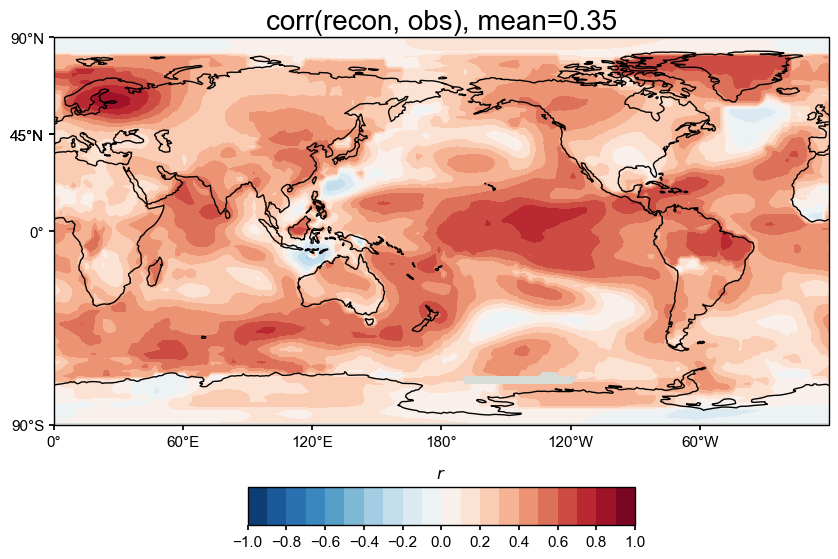

In [104]:
# Convert target data to 0-360 format first
target_wrapped = target_be.wrap_lon(mode='360')

# Then do the comparison
valid_fdb = res.recons['tas'].compare(
    target_wrapped,
    stat='corr',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdb.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdb.plot(
    title=f'corr(recon, obs), mean={valid_fdb.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
)

cfr.showfig(fig)

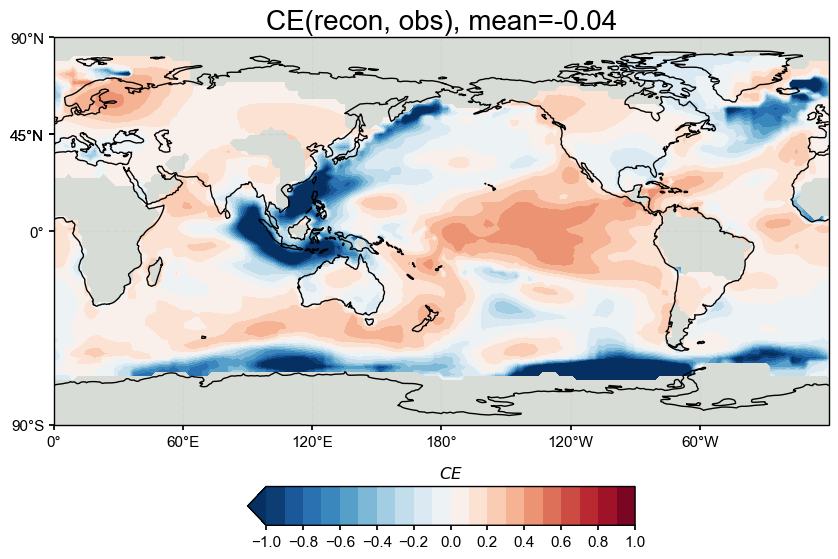

In [105]:
# Then do the comparison
valid_fdbx = res.recons['tas'].compare(
    target_wrapped,
    stat='CE',
    timespan=(1880, 2000),
)

# Plot with updated settings
valid_fdbx.plot_kwargs.update({'cbar_orientation': 'horizontal', 'cbar_pad': 0.1})
fig, ax = valid_fdbx.plot(
    title=f'CE(recon, obs), mean={valid_fdbx.geo_mean().value[0,0]:.2f}',
    projection='PlateCarree',
    latlon_range=(-90, 90, 0, 360),
    plot_cbar=True,
    plot_proxydb=False,
)

cfr.showfig(fig)